# Imports

In [26]:
#plot and handle
import pandas            as pd
import numpy             as np
import seaborn           as sns
import scikitplot        as skplt
import matplotlib.pyplot as plt
import matplotlib
import pickle

#display
from tabulate                   import tabulate
from IPython.core.display       import HTML
from numerize import numerize   as nm

#ML
from sklearn import neighbors     as nh
from sklearn import linear_model  as lm
from sklearn import ensemble      as en
from xgboost import XGBClassifier

## Path Handlers

In [27]:
path_data = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/data/'
model_data = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/models/'

## Functions

In [28]:
def jupyter_settings():
    """ Optimize general settings, standardize plot sizes, etc. """
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams['font.size'] = 20
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.max_columns', 30)
    pd.set_option('display.max_rows', 30)
jupyter_settings()

#gain_lift_curve

def lift_curve(yhat, yval, plot = True, size = (6,8), axvline="None"):
    '''
    Função para plotar o ganho e a curva de lift, respectivamente
    retona as curvas e uma tabela para plotar as curvas
    '''

    table_proba = pd.DataFrame(yhat)

    table_proba['target'] = yval.values

    #Coluna para avaliar se a previsão estava certa ou não.
    x = lambda x: 'yes' if x[0] > x[1] and x['target'] == 0 else 'yes' if x[1] > x[0] and x['target'] == 1 else 'no'
    table_proba['correct'] = table_proba.apply(x, axis = 1)

    # order by propensity score for the class 1
    table_proba.sort_values(1, ascending = False, inplace = True)

    #Criando a pontuação de propensão acumulativa e 

    #Calcular a quantidade de linhas de classe 1
    classe_1 = table_proba.groupby('target').count().loc[1,1]

    #Aplicando uma pontuação para cada linha cujo alvo é 1
    x = lambda x: 1/classe_1 if x['target'] == 1 else 0
    table_proba['propensity_score'] = table_proba.apply(x, axis=1)
    table_proba['cumulative_propensity_score'] = np.cumsum(table_proba['propensity_score'])

    #Criando a % do acumulativo

    x = lambda x: 1/len(table_proba)
    table_proba['porc_base'] = table_proba.apply(x, axis=1)
    table_proba['cumulative_porc_base'] = np.cumsum(table_proba['porc_base'])
    table_proba.drop('porc_base', axis = 1, inplace = True)

    #Criando a coluna do lift
    table_proba['lift'] = table_proba['cumulative_propensity_score'] / table_proba['cumulative_porc_base']

    if plot:
    
        fig, axes = plt.subplots(2, 1, figsize=size)

        # gap between graphics
        fig.tight_layout(pad =5)

        # gain curve
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_propensity_score'], label="cumulative (model)", linewidth = 2.5);
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_porc_base'], label="baseline", linewidth = 2.5, color = 'black' )
        axes[0].lines[1].set_linestyle("--")
        axes[0].legend()
        axes[0].set_title("cumulative gains curve")
        axes[0].set_xlabel("percentage of sample")
        axes[0].set_ylabel("gain")
        
        if axvline != "None":
            
            axes[0].axvline(axvline, 0, 1, color='green', ls='--', lw=2)
        
        # lift curve
        ## do not consider the beginning of the series, as it varies a lot (the sample is still small)
        table_proba_filtered = table_proba.query('cumulative_porc_base >= 0.1')

        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = table_proba_filtered['lift'], label="model", linewidth = 2.5 );
        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = np.ones(len(table_proba_filtered)), label="baseline", linewidth = 2.5, color = 'black' )
        axes[1].lines[1].set_linestyle("--")
        axes[1].legend()
        axes[1].set_title("lift curve")
        axes[1].set_xlabel("percentage of sample")

        if axvline != "None":
            axes[1].axvline(axvline, 0, 1, color='green', ls='--', lw=2)
        
        plt.show();
        
    return (table_proba)

# Funçoes que avalia a performance dos modelos

#Precision at K
def precision_at_k(data, yhat_model, k=2000):

    '''
    Recebe um conjunto de dados e retorna:
    Uma tupla contendo a precisão em K e recall K respectivamente.
    Uma nova tabela com as metricas precision_at_k e recall_at_k
    '''

    #propensity score
    data['score'] = yhat_model[:, 1].tolist()

    #Sorte clients by propensity score
    data = data.sort_values(by='score', ascending=False)

    #Reset index
    data = data.reset_index(drop=True)

    #create ranking order
    data['ranking'] = data.index + 1 #Criando um ranking

    data['precision_at_K'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_K']

#Recall at_K
def recall_at_k(data,yhat_model, k=2000):

    #propensity score
    data['score'] = yhat_model[:, 1].tolist()

    #Sorte clients by propensity score
    data = data.sort_values(by='score', ascending=False)

    #Reset index
    data = data.reset_index(drop=True)

    #create ranking order
    data['ranking'] = data.index + 1 #Criando um ranking

    data['recall_at_K'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_K']


#Precision Recall K
def precision_recall (table, k=2000):

    table = table.reset_index(drop=True)

    table['ranking'] = table.index + 1

    table['precision_at_k'] = table['target'].cumsum() / table['ranking']
    table['recall_at_k'] = table['target'].cumsum() / table['target'].sum()

    return ((table.loc[k-1, 'precision_at_k'], table.loc[k-1, 'recall_at_k']), table) # como o loc usa index, é necessário -1 para retornar o k desejado

## Load Data

In [29]:
#Train
x_train = pd.read_csv(path_data+'x_train.csv', index_col=0)
y_train = pd.read_csv(path_data+'y_train.csv', index_col=0)

#Validação
x_val = pd.read_csv(path_data+'x_val.csv', index_col=0)
y_val = pd.read_csv(path_data+'y_val.csv', index_col=0)


In [30]:
print('x_train -> ',x_train.shape)
print('y_train -> ',y_train.shape)
print('x_val -> ',x_val.shape)
print('y_val -> ',y_val.shape)

x_train ->  (274398, 7)
y_train ->  (274398, 1)
x_val ->  (30489, 7)
y_val ->  (30489, 1)


# Machine Learning

* Dado o problema de negócio, o objetivo do projeto é constuir uma lista ordenada de propensão de compra, e descobrir qual probabilidade do cliente comprar ou não o seguro de automovel.

* Iremos testar alguns modelos e escolher o que obter o melhor desempenho baseado nas metricas de classificação, Precision_at_k e Recall_at_k.

* Iremos iniciar uma analise preliminar com os modelos, obtendo desempenho unico de cada modelo;

* Evoluindo essa fase, será realizada uma análise mais detalhada com cada modelo, por meio de validação cruzada (Cross Validation) e ajuste de Hiperparâmetros (Fine Tuning).

## KNN

In [31]:
#model definition
knn = nh.KNeighborsClassifier(n_neighbors= 8)

#model Training
knn.fit(x_train, y_train.values.ravel())

#Model predict (probabilidade)
yhat_knn = knn.predict_proba(x_val);

## Logistic Regression

In [32]:
#model definition
lr = lm.LogisticRegression(random_state=42)

#model Training
lr.fit(x_train, y_train.values.ravel())

#Model predict (probabilidade)
yhat_lr = lr.predict_proba(x_val);

## Extra Trees

In [33]:
#model definition
et = en.ExtraTreesClassifier(n_estimators=150, random_state=30, n_jobs=-1)

#model Training
et.fit(x_train, y_train.values.ravel())

#Model predict (probabilidade)
yhat_et = et.predict_proba(x_val);

## XGBoost

In [34]:
#model definition
xgb = XGBClassifier()
#model Training
xgb.fit(x_train, y_train.values.ravel())

#Model predict (probabilidade)
yhat_xgb = xgb.predict_proba(x_val);

## Avaliação dos modelos

##### Avaliando as metricas:

- Para cada modelo, uma curva de ganho e elevação acumulativa será criada.

#### Curva de ganhos acumulado:
- A tabela é ordenada por probabilidade de compra, cruza o percentual da base de clientes com o percentual de clientes propensos a compra.

##### EX:
- 30% da base de cleintes (x), ordenada pela probanilidade de compra (y), contem 60% de todos os interessados em adquirir o seguro de veiculos.

#### Curva de Lift:
- Representa a diferença entre a curva de ganho e a lista aleatoria. Portanto, ele informa o quanto o modelo é melhor em comparação com a lista aleatória.

##### EX:
- Ao se aproximar de 30% d lista ordenada, o modelo esta ~2.2 vezes melhor que a lista aleatoria.

#### Para todos os modelos, tambem será calculado o Precision e Recall em K:

##### Precision TOP K: 
- Conta quanta previsões foram correntas até k e divide por toda as previsões feitas ate k.

##### EX1: 
- Precisão no top 10% (ou 3049) k = 0,40 - Significa que em 10% da base, o modelo acertou 40% em relação ao modelo perfeito, que acertaria 100 no top 10%, sendo que neste caso teriamos 12% do total de clientes interessados(Sem erro até 12%).

##### EX1: 
- Precisão no Top 40% (ou 12196) k = 0.25 - Significa que em 40% da base, o modelo acertou 25% em relação ao modelo perfeito, que acertaria 60% no top 40%, sendo que depois de 12%, deu tudo certo, e agora so vai ladeira abaixo.

## KNN

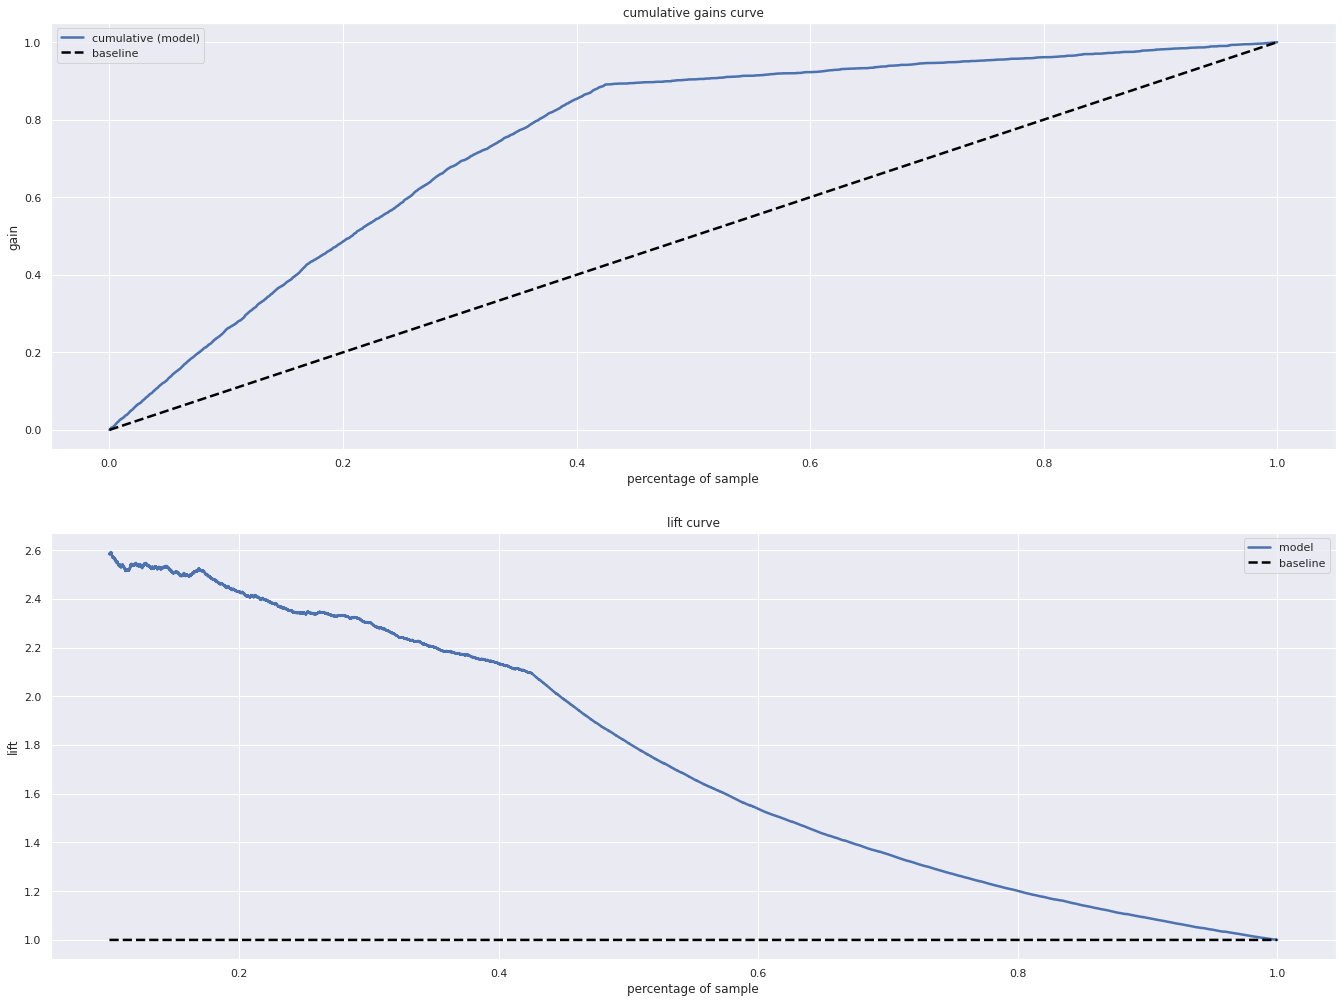

In [35]:
table_knn = lift_curve(yhat_knn, y_val, plot = True, size = (20,15), axvline="None")

##### Gain : Ao se aproxima de 40% da lista de pedidos, ~85% de todos os clientes interessados são alcançados.
##### Lift: Ao se aproximade de 40% da lista ordenada, o modelo tem um desempenho  ~2,2 vezes melhor que a lista aleatória.

### Precision@k e Recall@k KNN

In [36]:
metrics_knn, new_table_knn = precision_recall(table_knn, 12200)

In [37]:
new_table_knn

,0,1,target,correct,propensity_score,cumulative_propensity_score,cumulative_porc_base,lift,ranking,precision_at_k,recall_at_k
0,0.000,1.000,0,no,0.000000,0.000000,0.000033,0.000000,1,0.000000,0.000000
1,0.000,1.000,1,yes,0.000268,0.000268,0.000066,4.080434,2,0.500000,0.000268
2,0.000,1.000,0,no,0.000000,0.000268,0.000098,2.720289,3,0.333333,0.000268
3,0.125,0.875,1,yes,0.000268,0.000535,0.000131,4.080434,4,0.500000,0.000535
4,0.125,0.875,0,no,0.000000,0.000535,0.000164,3.264347,5,0.400000,0.000535
...,...,...,...,...,...,...,...,...,...,...,...
30484,1.000,0.000,0,yes,0.000000,1.000000,0.999869,1.000131,30485,0.122552,1.000000
30485,1.000,0.000,0,yes,0.000000,1.000000,0.999902,1.000098,30486,0.122548,1.000000
30486,1.000,0.000,0,yes,0.000000,1.000000,0.999934,1.000066,30487,0.122544,1.000000
30487,1.000,0.000,0,yes,0.000000,1.000000,0.999967,1.000033,30488,0.122540,1.000000


Existem 3.737 de 12.200 linhas com recurso de destino de classe 1, portanto, a precisão máxima que pode ser obtida é de ~ 30% (3737/12.200)

In [38]:
display(y_val.value_counts())

response
0           26753
1            3736
dtype: int64

In [39]:
print(f"KNN - \nPrecision at 40% of base(k): {round( metrics_knn[0] ,2)}\nRecall at 40% of base(k): {round( metrics_knn[1] ,2) }")

KNN - 
Precision at 40% of base(k): 0.26
Recall at 40% of base(k): 0.85


##### Precisão no top 40% da base(k): 
    - Significa que em 40% da base, o modelo acertou 26% em relação ao modelo perfeito,
    - que acertaria ~60% no top 40%, sendo que após 12% , deu tudo certo, e agora só vai ladeira abaixo.

##### Recall no top 40% da base(k): 
    - Significa que 86% do total de clientes interessados aparecem nos resultados top 40% da lista ordenada.

## Logistic Regression

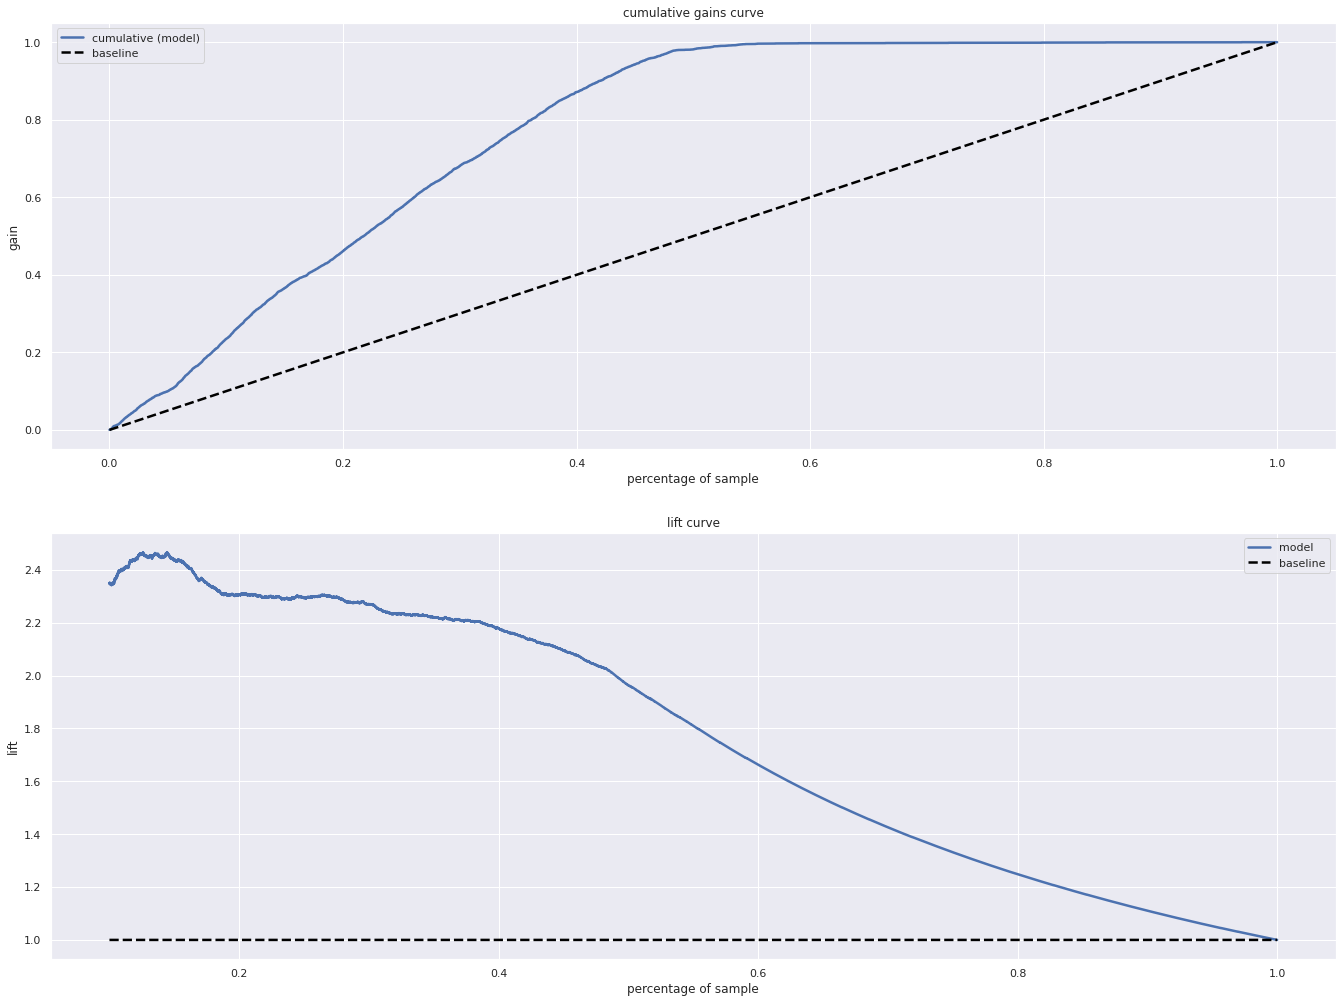

In [40]:
table_lr = lift_curve(yhat_lr, y_val, plot = True, size = (20,15), axvline="None")

##### Gain : Ao se aproxima de 40% da lista de pedidos, ~87% de todos os clientes interessados são alcançados.
##### Lift: Ao se aproximade de 40% da lista ordenada, o modelo tem um desempenho  ~2,1 vezes melhor que a lista aleatória.

### Precision@k e Recall@k Logistic Regression

In [41]:
metrics_lr, new_table_lr = precision_recall(table_lr, 12200)

In [42]:
new_table_lr

,0,1,target,correct,propensity_score,cumulative_propensity_score,cumulative_porc_base,lift,ranking,precision_at_k,recall_at_k
0,0.651318,0.348682,1,no,0.000268,0.000268,0.000033,8.160867,1,1.000000,0.000268
1,0.654482,0.345518,0,yes,0.000000,0.000268,0.000066,4.080434,2,0.500000,0.000268
2,0.656493,0.343507,0,yes,0.000000,0.000268,0.000098,2.720289,3,0.333333,0.000268
3,0.657297,0.342703,0,yes,0.000000,0.000268,0.000131,2.040217,4,0.250000,0.000268
4,0.657631,0.342369,0,yes,0.000000,0.000268,0.000164,1.632173,5,0.200000,0.000268
...,...,...,...,...,...,...,...,...,...,...,...
30484,0.999581,0.000419,0,yes,0.000000,1.000000,0.999869,1.000131,30485,0.122552,1.000000
30485,0.999585,0.000415,0,yes,0.000000,1.000000,0.999902,1.000098,30486,0.122548,1.000000
30486,0.999586,0.000414,0,yes,0.000000,1.000000,0.999934,1.000066,30487,0.122544,1.000000
30487,0.999594,0.000406,0,yes,0.000000,1.000000,0.999967,1.000033,30488,0.122540,1.000000


Existem 3.737 de 12.200 linhas com recurso de destino de classe 1, portanto, a precisão máxima que pode ser obtida é de ~ 30% (3737/12.200)

In [43]:
display(y_val.value_counts())

response
0           26753
1            3736
dtype: int64

In [44]:
print(f"Logistic Regression - \nPrecision at 40% of base(k): {round( metrics_lr[0] ,2)}\nRecall at 40% of base(k): {round( metrics_lr[1] ,2) }")

Logistic Regression - 
Precision at 40% of base(k): 0.27
Recall at 40% of base(k): 0.87


##### Precisão no top 40% da base(k): 
    - Significa que em 40% da base, o modelo acertou 27% em relação ao modelo perfeito,
    - que acertaria ~60% no top 40%, sendo que após 12% , deu tudo certo, e agora só vai ladeira abaixo.

##### Recall no top 40% da base(k): 
    - Significa que 87% do total de clientes interessados aparecem nos resultados top 40% da lista ordenada.

## Extra Trees

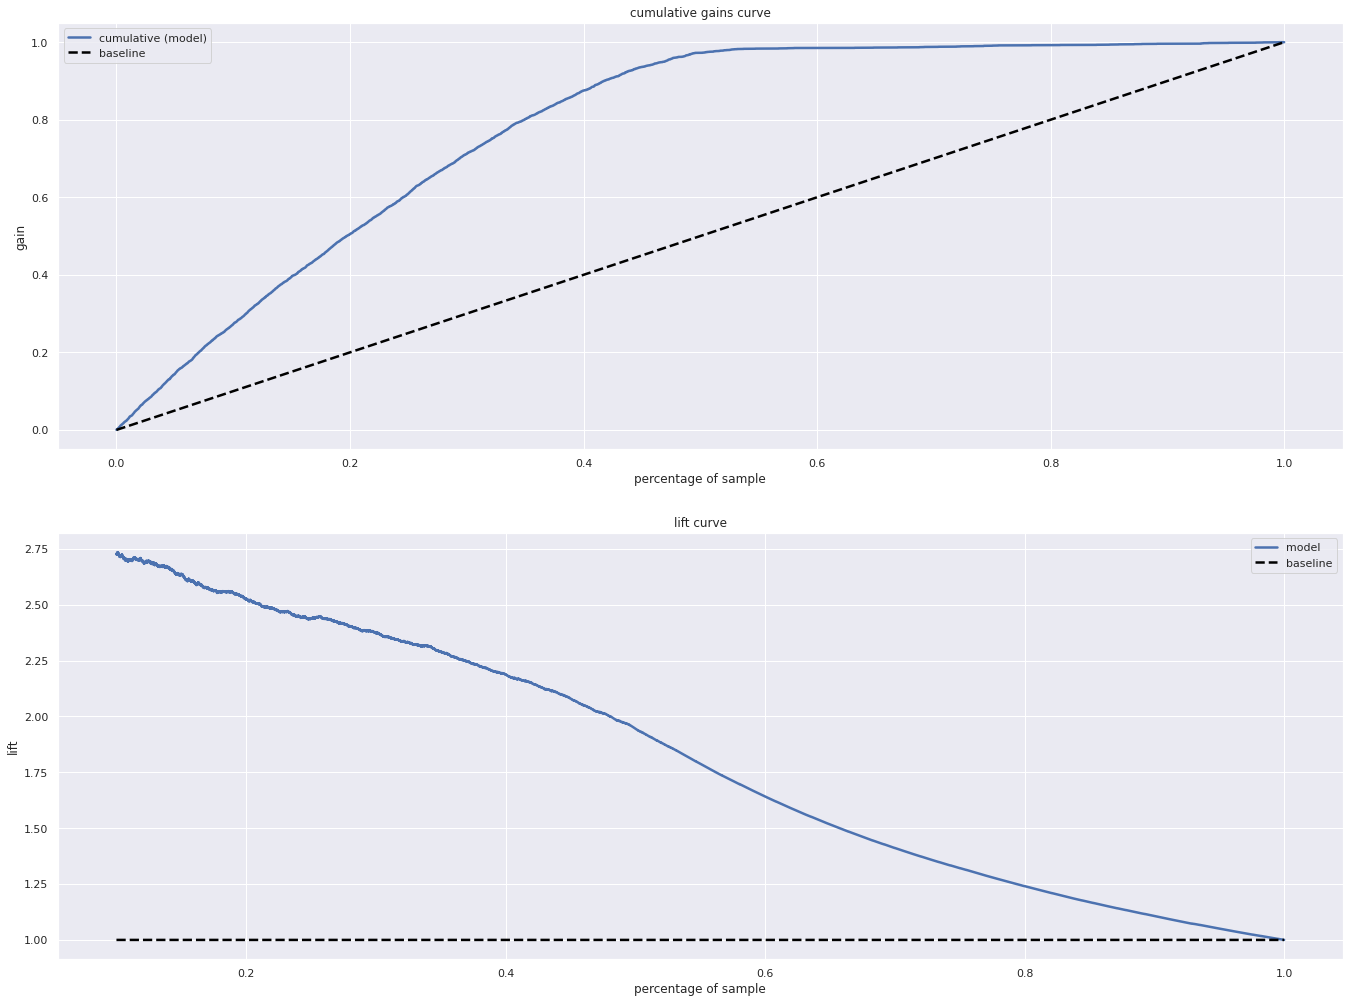

In [45]:
table_et = lift_curve(yhat_et, y_val, plot = True, size = (20,15), axvline="None")

##### Gain : Ao se aproxima de 40% da lista de pedidos, ~88% de todos os clientes interessados são alcançados.
##### Lift: Ao se aproximar de 40% da lista ordenada, o modelo tem um desempenho  ~2,2 vezes melhor que a lista aleatória.

### Precision@k e Recall@k Extra Trees

In [46]:
metrics_et, new_table_et = precision_recall(table_et, 12200)

Existem 3.737 de 12.200 linhas com recurso de destino de classe 1, portanto, a precisão máxima que pode ser obtida é de ~ 30% (3737/12.200)

In [47]:
display(y_val.value_counts())

response
0           26753
1            3736
dtype: int64

In [48]:
print(f"Logistic Regression - \nPrecision at 40% of base(k): {round( metrics_et[0] ,2)}\nRecall at 40% of base(k): {round( metrics_et[1] ,2) }")

Logistic Regression - 
Precision at 40% of base(k): 0.27
Recall at 40% of base(k): 0.88


##### Precisão no top 40% da base(k): 
    - Significa que em 40% da base, o modelo acertou 27% em relação ao modelo perfeito,
    - que acertaria ~60% no top 40%, sendo que após 12% , deu tudo certo, e agora só vai ladeira abaixo.

##### Recall no top 40% da base(k): 
    - Significa que 88% do total de clientes interessados aparecem nos resultados top 40% da lista ordenada.

## XGBoost

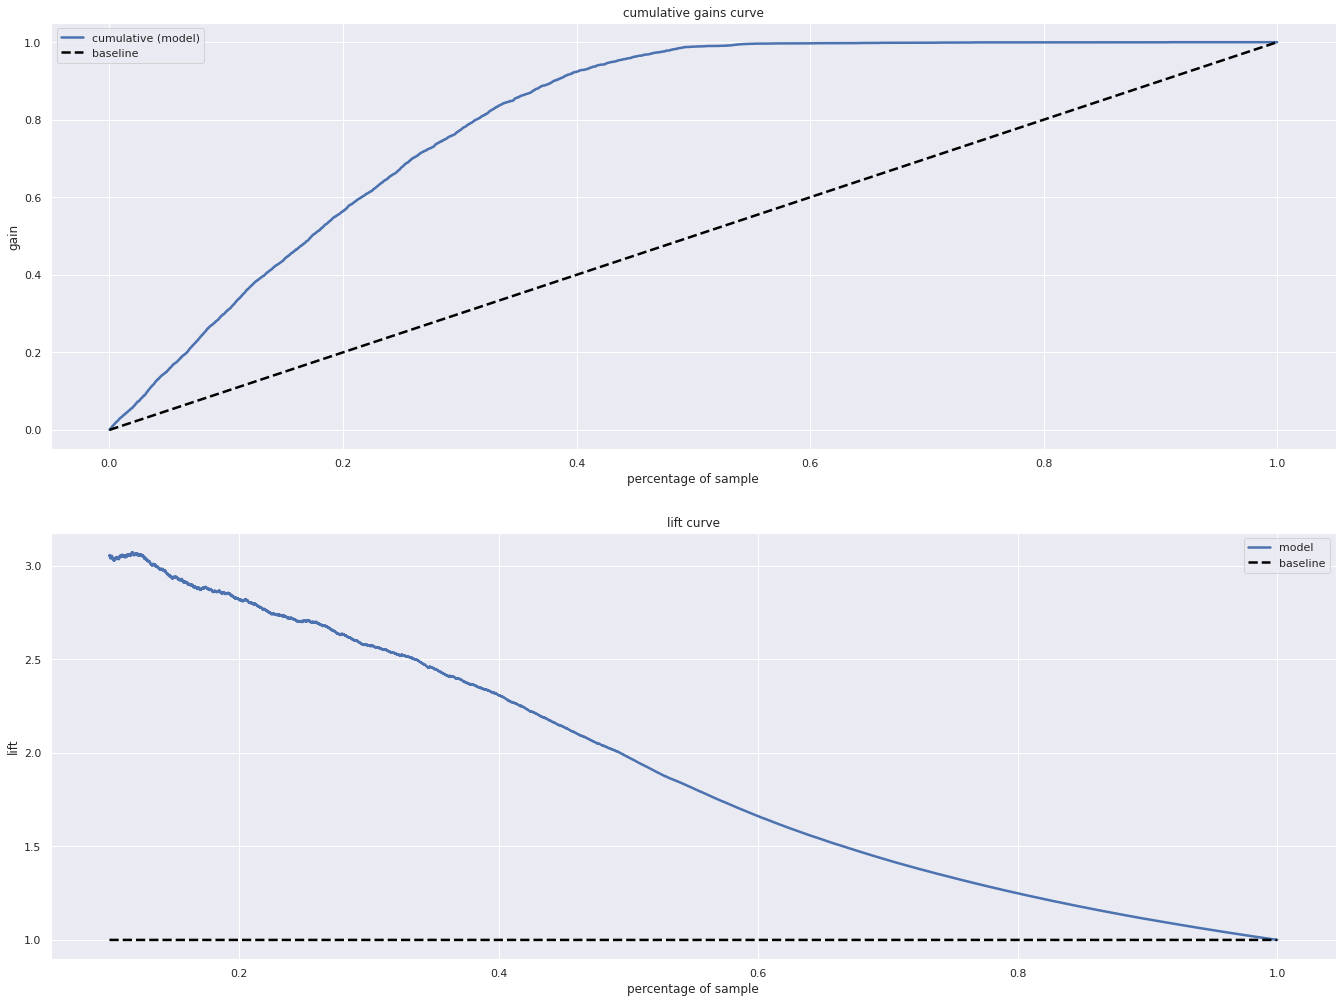

In [49]:
table_xgb = lift_curve(yhat_xgb, y_val, plot = True, size = (20,15), axvline="None")

##### Gain : Ao se aproxima de 40% da lista de pedidos, ~92% de todos os clientes interessados são alcançados.
##### Lift: Ao se aproximar de 40% da lista ordenada, o modelo tem um desempenho  ~2,3 vezes melhor que a lista aleatória.

### Precision@k e Recall@k XGboost

In [50]:
metrics_xgb, new_table_xgb = precision_recall(table_xgb, 12200)

Existem 3.737 de 12.200 linhas com recurso de destino de classe 1, portanto, a precisão máxima que pode ser obtida é de ~ 30% (3737/12.200)

In [51]:
display(y_val.value_counts())

response
0           26753
1            3736
dtype: int64

In [52]:
print(f"Logistic Regression - \nPrecision at 40% of base(k): {round( metrics_xgb[0] ,2)}\nRecall at 40% of base(k): {round( metrics_xgb[1] ,2) }")

Logistic Regression - 
Precision at 40% of base(k): 0.28
Recall at 40% of base(k): 0.92


##### Precisão no top 40% da base(k): 
    - Significa que em 40% da base, o modelo acertou 28% em relação ao modelo perfeito,
    - que acertaria ~60% no top 40%, sendo que após 12% , deu tudo certo, e agora só vai ladeira abaixo.

##### Recall no top 40% da base(k): 
    - Significa que 92% do total de clientes interessados aparecem nos resultados top 40% da lista ordenada.

## Desempenho dos modelos

- Com base nesta primeira analise, Temos a comparação de cada modelo na tabela abaixo

- Considerando K = 40% da Base.

In [53]:
prec_at_k_knn, recall_at_k_knn = metrics_knn
prec_at_k_lr, recall_at_k_lr = metrics_lr
prec_at_k_et, recall_at_k_et = metrics_et
prec_at_k_xgb, recall_at_k_xgb = metrics_xgb

dict_sing_perf = {
    'model': ['KNN', 'Logistic Regression', 'Extra Trees', 'XGBoost'],
    'precision_at_k': [prec_at_k_knn, prec_at_k_lr, prec_at_k_et, prec_at_k_xgb],
    'recall_at_k': [recall_at_k_knn, recall_at_k_lr, recall_at_k_et, recall_at_k_xgb]
}
df_single_perf = pd.DataFrame(dict_sing_perf)
df_single_perf

,model,precision_at_k,recall_at_k
0,KNN,0.261393,0.853587
1,Logistic Regression,0.266803,0.871253
2,Extra Trees,0.268115,0.875535
3,XGBoost,0.282787,0.923448


#### Finalizamos a primeira analise, agora iremos se aprofundar em duas situações:

- 1 - Precisamos de uma amostragem mais justa, pois da forma que foi construido o modelo pode ter selecionado um a boa amostra, devido ao viés de seleção, para resolvermos este problema irei utilizar a validação cruzada.

- 2 - Precisamos tambem melhorar as configurações dos modelos, para isso iremos realizar uma ajuste fino dos hiperparâmetros.

## Analise detalhada

#### Nesta seção, será feito uma analise detalhada para cada modelos em um arquivo especifico.

- Em cada arquivo, será realizado os ajustes de hiperparametros, que visa identificar o melhor conjunto de parâmetros para cada modelo, a fim de maximizar sua capacidade de aprendizado.
- Irei utilizar a tecnica de ramdom Search, onde valores possiveis são predefinidos para cada paramentro do modelo, onde será testado aleatoriamente esses parametros até que o modelo identifique o melhor conjunto.
- Para cada execução do modelo, é aplicada uma validação crizada que faz 10 cortes no espaço dos dados, a fim de reduzir o vies de seleção de dados (teoria da amostragem).
- Apos todos esses testes para cada modelo aqui apresentado, os dados serão tabulados para identificar o modelo com os melhores resultados. Uma versão final do modelo será executada nesse script, com os melhores hiperparametros, gerando a sua curva de GAIN Acumulativo, Lift, precission K e Recall K.

- Apos a Criação de todos os modelos, os dados serão exportados para que os resultados dos modelos possam ser comprados na seção a seguir.

### Carregando os modelos das listas de testes, utilizando o cross Validation e Grid Search

In [54]:
# load model's ranked list
df_knn = pd.read_pickle(model_data+'knn_table_final.pkl')
df_lr =  pd.read_pickle(model_data+'LogisticRegression_table_final.pkl')
df_et =  pd.read_pickle(model_data+'ExtraTrees_table_final.pkl')
df_xgb = pd.read_pickle(model_data+'xgb_table_final.pkl')
df_perfect_model =  pd.read_pickle(model_data+'perfect_model_table.pkl')

# load test
x_test = pd.read_csv(path_data+'x_test.csv', index_col=0)
y_test = pd.read_csv(path_data+'y_test.csv', index_col=0)

cols_selected = ['days_associated','health_annual_paid','age','region_code',
                 'vehicle_damage','policy_sales_channel', 'vehicle_prev_insured']

#to make this section independent of the previous ones (only depending on the imports), just import training data here.

### Acumulativo

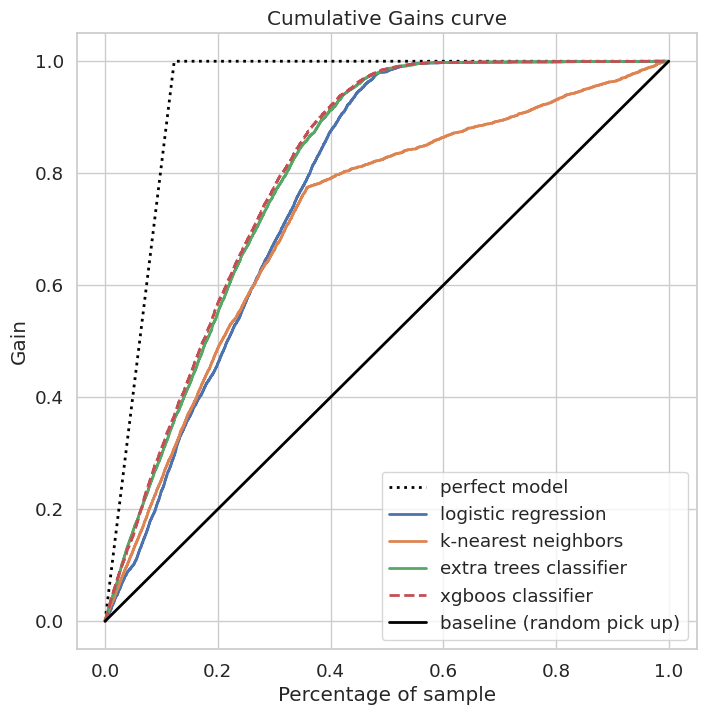

In [55]:
# restore to default matplotlib and seaborn configuration
matplotlib.rc_file_defaults()
sns.reset_orig
sns.set_theme(font_scale = 1.2, style = 'whitegrid')

# plot the graphics
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

# plot the graphics
sns.lineplot(ax = axes, x = df_perfect_model['cumulative_porc_base'], y = df_perfect_model['cumulative_propensity_score'], label="perfect model", linewidth = 2, color = 'black')
sns.lineplot(ax = axes, x = df_lr['cumulative_porc_base'], y = df_lr['cumulative_propensity_score'], label="logistic regression", linewidth = 2)
sns.lineplot(ax = axes, x = df_knn['cumulative_porc_base'], y = df_knn['cumulative_propensity_score'], label="k-nearest neighbors ", linewidth = 2)
sns.lineplot(ax = axes, x = df_et['cumulative_porc_base'], y = df_et['cumulative_propensity_score'], label="extra trees classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_xgb['cumulative_porc_base'], y = df_xgb['cumulative_propensity_score'], label="xgboos classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_perfect_model['cumulative_porc_base'], y = df_perfect_model['cumulative_porc_base'], label="baseline (random pick up)", linewidth = 2, color = 'black')

axes.lines[0].set_linestyle(":")
axes.lines[4].set_linestyle("--")

axes.legend()
axes.set_title("Cumulative Gains curve")
axes.set_xlabel("Percentage of sample")
axes.set_ylabel("Gain")

axes.plot;

### Curva de Lift

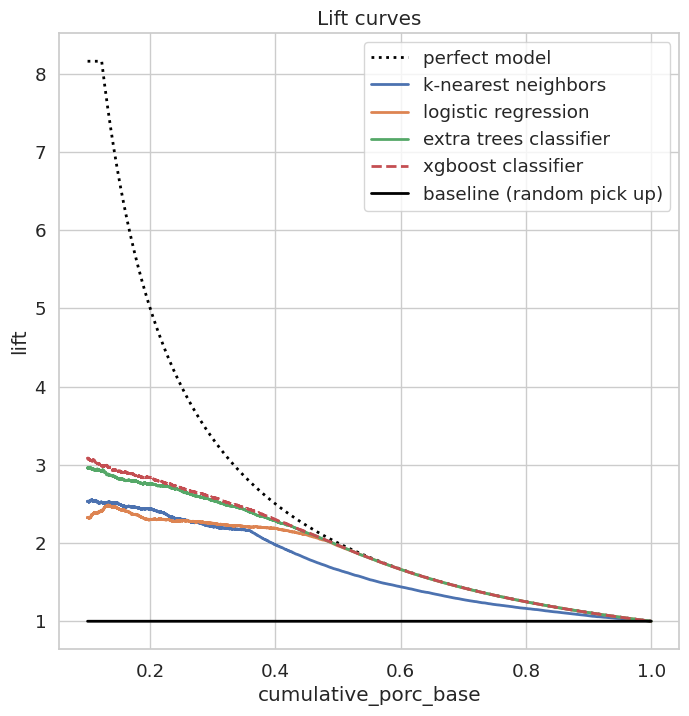

In [56]:
#sns.set()
sns.set_theme(font_scale = 1.2, style = 'whitegrid')

## do not consider the beginning of the series, as it varies a lot (the sample is still small)
df_knn_filtered = df_knn.query('cumulative_porc_base >= 0.1')
df_lr_filtered = df_lr.query('cumulative_porc_base >= 0.1')
df_et_filtered = df_et.query('cumulative_porc_base >= 0.1')
df_xgb_filtered = df_xgb.query('cumulative_porc_base >= 0.1')
df_perfect_model_filtered = df_perfect_model.query('cumulative_porc_base >= 0.1')

# plot the graphics
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

sns.lineplot(ax = axes, x = df_perfect_model_filtered['cumulative_porc_base'], y = df_perfect_model_filtered['lift'], label="perfect model", linewidth = 2, color = 'black')
sns.lineplot(ax = axes, x = df_knn_filtered['cumulative_porc_base'], y = df_knn_filtered['lift'], label="k-nearest neighbors ", linewidth = 2)
sns.lineplot(ax = axes, x = df_lr_filtered['cumulative_porc_base'], y = df_lr_filtered['lift'], label="logistic regression", linewidth = 2)
sns.lineplot(ax = axes, x = df_et_filtered['cumulative_porc_base'], y = df_et_filtered['lift'], label="extra trees classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_xgb_filtered['cumulative_porc_base'], y = df_xgb_filtered['lift'], label="xgboost classifier", linewidth = 2)
sns.lineplot(ax = axes, x = df_perfect_model_filtered['cumulative_porc_base'], y = np.ones(len(df_perfect_model_filtered)), label="baseline (random pick up)", linewidth = 2, color = 'black')

axes.lines[0].set_linestyle(":")
axes.lines[4].set_linestyle("--")

axes.legend()
axes.set_title("Lift curves")

axes.plot;

### Modelo Escolhido

- Apos todos os testes, iremos treinar o Classificador XGBoost com conjuntos de dados x_train e x_val e testar usando o conjunto de dados x_test.

- Dessa forma, será possivel comparar o desempenho do modelo com dados de treinamento e validação, e com dados de teste.

- Será então possivel avaliar a generalização do modelo, ou seja, a capacidade do modelo de classificar dados nunca vistos,

In [57]:
columns = ['vintage', 'annual_premium', 'age', 'region_code',
       'vehicle_damage', 'policy_sales_channel', 'previously_insured']

In [58]:
x_test1 = pd.read_csv(path_data+'x_test.csv')
y_test1 = pd.read_csv(path_data+'y_test.csv')

In [59]:
y_test1.drop('Unnamed: 0', axis=1, inplace=True)

In [60]:
# unify train and validation datasets
x_train = pd.concat([x_train, x_val])
y_train = pd.concat([y_train, y_val])


# model definition
xgbclassifier_model = XGBClassifier(n_estimators = 100,
                                    max_depth = 3,
                                    scale_pos_weight = 1,
                                    n_jobs= -1)

# model training
xgbclassifier_model.fit(x_train, y_train.values.ravel())

# model prediction (proba)
yhat_proba_xgb_final = xgbclassifier_model.predict_proba(x_test1[columns])

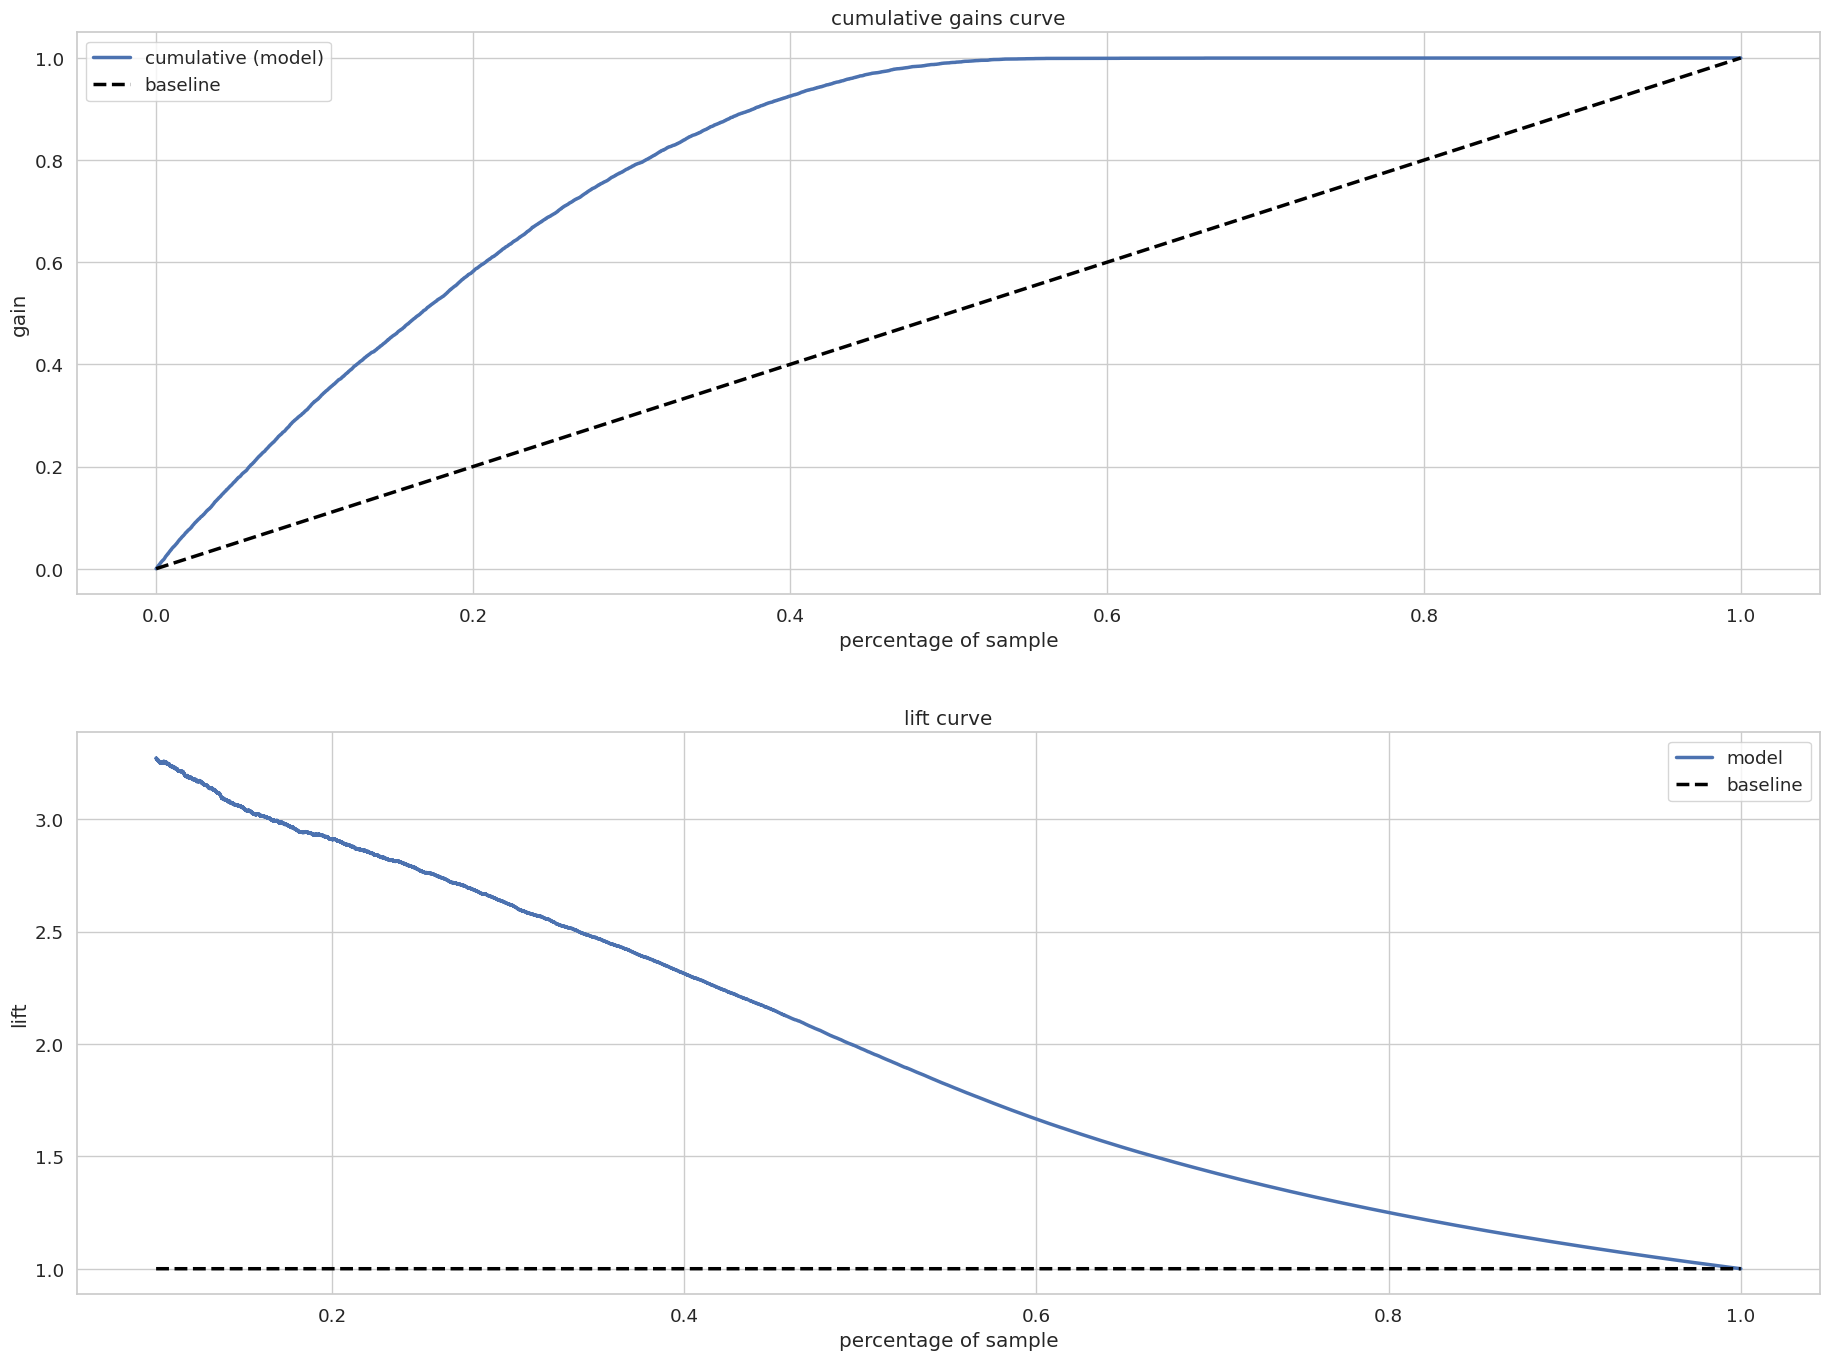

In [61]:
xgb_test = lift_curve(yhat_proba_xgb_final, y_test1, plot = True, size = (20,15))

In [62]:
# two dictionaies, one for each metric
dict_precision = {'Precision@': ['10%' , '20%', '30%', '40%']}
dict_recall = {'Recall@': ['10%', '20%', '30%', '40%']}

# metrics (precision@k and recall@k) for 10%, 20%, 30%, 40% of the ranked list resulting from train and validation datasets
metrics10_train, _ = precision_recall(table_xgb,3049)
metrics20_train, _ = precision_recall(table_xgb,6098)
metrics30_train, _ = precision_recall(table_xgb,9147)
metrics40_train, _ = precision_recall(table_xgb,12196)

# metrics (precision@k and recall@k) for 10%, 20%, 30%, 40% of the ranked list resulting from test dataset
metrics10_test, _ = precision_recall(xgb_test,7622)
metrics20_test, _ = precision_recall(xgb_test,15244)
metrics30_test, _ = precision_recall(xgb_test,22866)
metrics40_test, _ = precision_recall(xgb_test,30488)


# construction of the two dictionaries to include 2 columns, one for each dataset, and 4 rows, one for each percentage
# train and valdation
dict_precision['xgboost classifier (train)'] = [round(metrics10_train[0], 2),
                                                round(metrics20_train[0], 2),
                                                round(metrics30_train[0], 2), 
                                                round(metrics40_train[0], 2)]
# test
dict_precision['xgboost classifier (test)'] = [round(metrics10_test[0], 2),
                                               round(metrics20_test[0], 2),
                                               round(metrics30_test[0], 2), 
                                               round(metrics40_test[0], 2)]


# train and valdation
dict_recall['xgboost classifier (train)'] =     [round(metrics10_train[1], 2),
                                                round(metrics20_train[1], 2),
                                                round(metrics30_train[1], 2), 
                                                round(metrics40_train[1], 2)]
# test
dict_recall['xgboost classifier (test)'] = [round(metrics10_test[1], 2),
                                               round(metrics20_test[1], 2),
                                               round(metrics30_test[1], 2), 
                                               round(metrics40_test[1], 2)]

# convert the dictionary to dataframe
df_precision = pd.DataFrame(dict_precision).set_index('Precision@')
df_recall = pd.DataFrame(dict_recall).set_index('Recall@')

In [63]:
print(tabulate(df_precision, headers='keys', tablefmt='fancy_grid'))

╒══════════════╤══════════════════════════════╤═════════════════════════════╕
│ Precision@   │   xgboost classifier (train) │   xgboost classifier (test) │
╞══════════════╪══════════════════════════════╪═════════════════════════════╡
│ 10%          │                         0.37 │                        0.4  │
├──────────────┼──────────────────────────────┼─────────────────────────────┤
│ 20%          │                         0.35 │                        0.36 │
├──────────────┼──────────────────────────────┼─────────────────────────────┤
│ 30%          │                         0.32 │                        0.32 │
├──────────────┼──────────────────────────────┼─────────────────────────────┤
│ 40%          │                         0.28 │                        0.28 │
╘══════════════╧══════════════════════════════╧═════════════════════════════╛


In [64]:
print(tabulate(df_recall, headers='keys', tablefmt='fancy_grid'))

╒═══════════╤══════════════════════════════╤═════════════════════════════╕
│ Recall@   │   xgboost classifier (train) │   xgboost classifier (test) │
╞═══════════╪══════════════════════════════╪═════════════════════════════╡
│ 10%       │                         0.31 │                        0.33 │
├───────────┼──────────────────────────────┼─────────────────────────────┤
│ 20%       │                         0.56 │                        0.58 │
├───────────┼──────────────────────────────┼─────────────────────────────┤
│ 30%       │                         0.77 │                        0.79 │
├───────────┼──────────────────────────────┼─────────────────────────────┤
│ 40%       │                         0.92 │                        0.93 │
╘═══════════╧══════════════════════════════╧═════════════════════════════╛


- Observamos que o modelo teve um desempenho muito semelhante, tanto usando dados de treinamento e validação quanto usando dados de teste (Não usados anteriormente).
- A capacidade de generalização é, portanto, bastante satisfatória, e o modelo será capaz de classificar dados nunca vistos de forma satisfatória.
#### Portando este modelo foi o escolhido para ser colocado em produção.

In [65]:
# save production model
pickle.dump(xgbclassifier_model, open(model_data +'xgbclassifier_model.pkl', 'wb'))

### Resultados Financeiros e Comerciais

- Nesta seção, serão demonstradas as estimativas de ganhos operacionais e financeiro com a implantação do modelo final em produção. 

## Qual a porcentagem de clientes interessados em adquirir um seguro de veículo que a equipe de vendas poderá contatar fazendo 20.000 ligações?

In [66]:
data = x_test1.copy()
data['target'] = y_test1.copy()

data['response'] = yhat_proba_xgb_final[:, 1].tolist()
data = data.sort_values('response', ascending=False).drop('Unnamed: 0', axis=1)

In [67]:
clientes = data.count()[0]
print('Temos {} novos clientes.'.format(clientes))

Temos 76219 novos clientes.


In [68]:
percent_at_20 = 20000 / len(data)
recall_at_20k, table_20k = precision_recall(data, k=20000)

print(percent_at_20)
print(recall_at_20k[1])

0.26240176333984966
0.7186262972076602


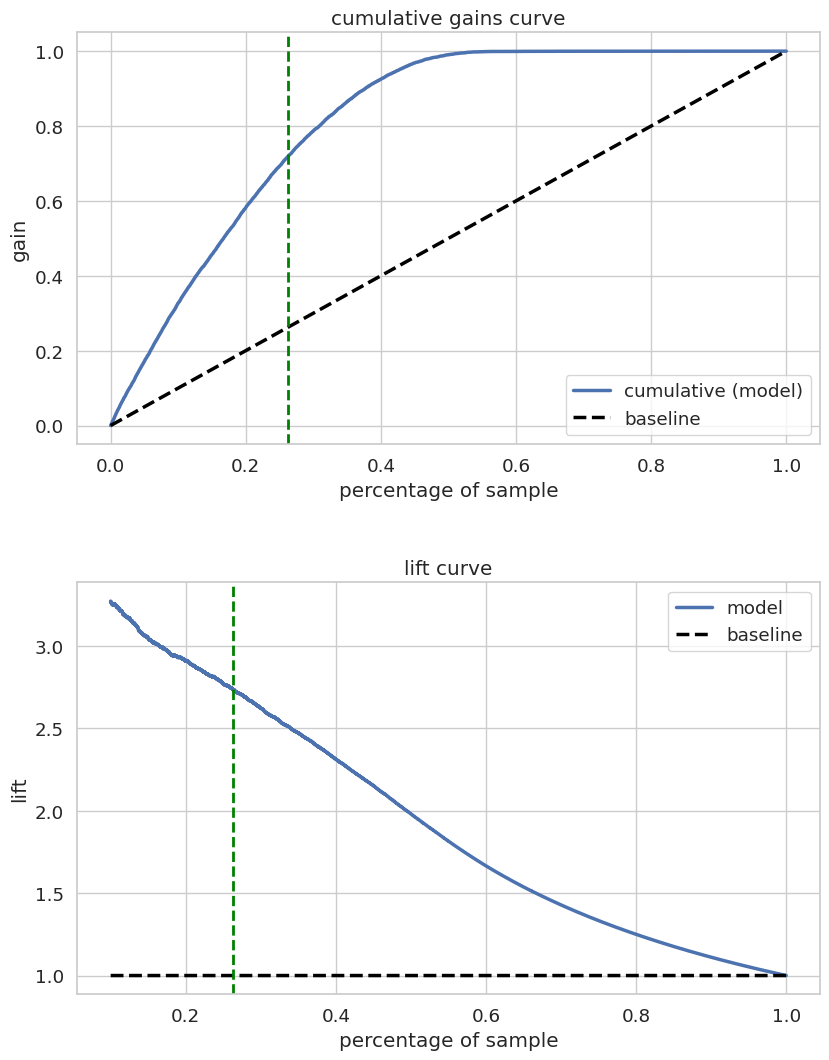

In [69]:
curves_at_20k = lift_curve(yhat_proba_xgb_final, y_test1, size = (10, 12), axvline= percent_at_20)

In [70]:
data

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_1-2 Year,vehicle_age_< 1 Year,vehicle_age_> 2 Years,target,response
1872,79459,0.137955,0.421875,0.186997,0.194741,1,1,0,12.187035,0.391003,1,0,0,0,0.567183
67631,222778,0.104423,0.421875,0.121726,0.208858,1,1,0,4.413690,0.460208,1,0,0,1,0.563801
16720,258555,0.137955,0.500000,0.186997,0.208858,1,1,0,4.526657,0.896194,0,0,1,0,0.553413
6678,314502,0.137955,0.359375,0.186997,0.001332,1,1,0,5.359482,0.657439,1,0,0,0,0.545990
67898,103932,0.137955,0.171875,0.110915,0.194741,1,1,0,-0.487200,0.996540,0,1,0,1,0.543130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43670,244033,0.137955,0.781250,0.065615,0.353393,1,0,1,-0.591686,0.709343,1,0,0,0,0.000090
31782,161196,0.104423,0.843750,0.071846,0.353393,1,0,1,-1.608096,0.816609,1,0,0,0,0.000089
63064,286724,0.104423,0.890625,0.084973,0.353393,1,0,1,-0.798983,0.505190,1,0,0,0,0.000089
42780,144646,0.137955,0.921875,0.103189,0.353393,1,0,1,-1.608096,0.131488,1,0,0,0,0.000087


In [71]:
## Cenario com 20000 ligações.

df_fin = pd.read_csv(path_data+'df4_Feature_Engineering.csv', index_col=0)

print (f"Temos {data.shape[0]} novos clientes, dos quais {round(data.loc[data['target'] == 1].shape[0])} estão interessados no seguro de veiculos. ({round(data.loc[data['target'] == 1].shape[0] / data.shape[0] *100 ,2) }% do total de novos clientes)")

print (f"O ticket médio para um seguro de saúde anual da Insurance All é de: ${round(df_fin['annual_premium'].median())}.")

print (f"\nAssumindo que todos os clientes interessados no seguro de veículo irão contratar o seguro de automovel, e que o valor médio do seguro do veículo será o mesmo do seguro de saúde, podemos estimar como cenario de faturamento:")

print (f"\n_______________________________ Cenario para 20000 Ligações telefonica _____________________________________________________________________________")
print (f"Pela Lista Aleatória:")
print (f" - A equipe de vendas contata {round(20000 / data.shape[0]*100 )}% dos interessados em seguro de carro: {round( (20000 / data.shape[0]*100 ) / 100 * (round(data.loc[data['target'] == 1].shape[0])) )} clientes (Ganho: Linha preta x linha Verde).\n  ==>  Receita estimada: 2451 * 31669 = ${nm.numerize(77620719)} por ano.")       

print (f"\nPela Lista ordenada (modelo):")
print (f" - A equipe de vendas contata {round(recall_at_20k[1]*100)}% dos interessados em seguro de automovel: {round( recall_at_20k[1]*100  / 100 * (data.loc[data['target'] == 1].shape[0]) )} Clientes (Ganho: cruzamento linha azul x linha verde).\n  ==> Receita Estimada: {round( recall_at_20k[1]*100  / 100 * (data.loc[data['target'] == 1].shape[0]) )} * 31669 = ${nm.numerize(208255344)} por ano.")

print (f"\nRESULTADO: O modelo é {round(208255344 / 77620719 ,2)} vezes melhor que a lista aleatória (Lift: Intereseção linha azul x verde). \nPortando, a receita estimada é de {round(208255344 / 77620719 ,2)} vezes maior que a lista aleatória: ${nm.numerize(208255344 - 77620719)}.")

Temos 76219 novos clientes, dos quais 9347 estão interessados no seguro de veiculos. (12.26% do total de novos clientes)
O ticket médio para um seguro de saúde anual da Insurance All é de: $31683.

Assumindo que todos os clientes interessados no seguro de veículo irão contratar o seguro de automovel, e que o valor médio do seguro do veículo será o mesmo do seguro de saúde, podemos estimar como cenario de faturamento:

_______________________________ Cenario para 20000 Ligações telefonica _____________________________________________________________________________
Pela Lista Aleatória:
 - A equipe de vendas contata 26% dos interessados em seguro de carro: 2453 clientes (Ganho: Linha preta x linha Verde).
  ==>  Receita estimada: 2451 * 31669 = $77.62M por ano.

Pela Lista ordenada (modelo):
 - A equipe de vendas contata 72% dos interessados em seguro de automovel: 6717 Clientes (Ganho: cruzamento linha azul x linha verde).
  ==> Receita Estimada: 6717 * 31669 = $208.26M por ano.

RESUL

## E se a capacidade da equipe de vendas aumenta-se para 40.000 ligações, que porcentagem de clientes interessados em Adquirir o seguro de veículos a equipe poderá contatar?

In [72]:
percent_at_40 = 40000 / len(data)
recall_at_40k, table_40k = precision_recall(data, k=40000)

print(percent_at_40)
print(recall_at_40k[1])

0.5248035266796993
0.9956135658500054


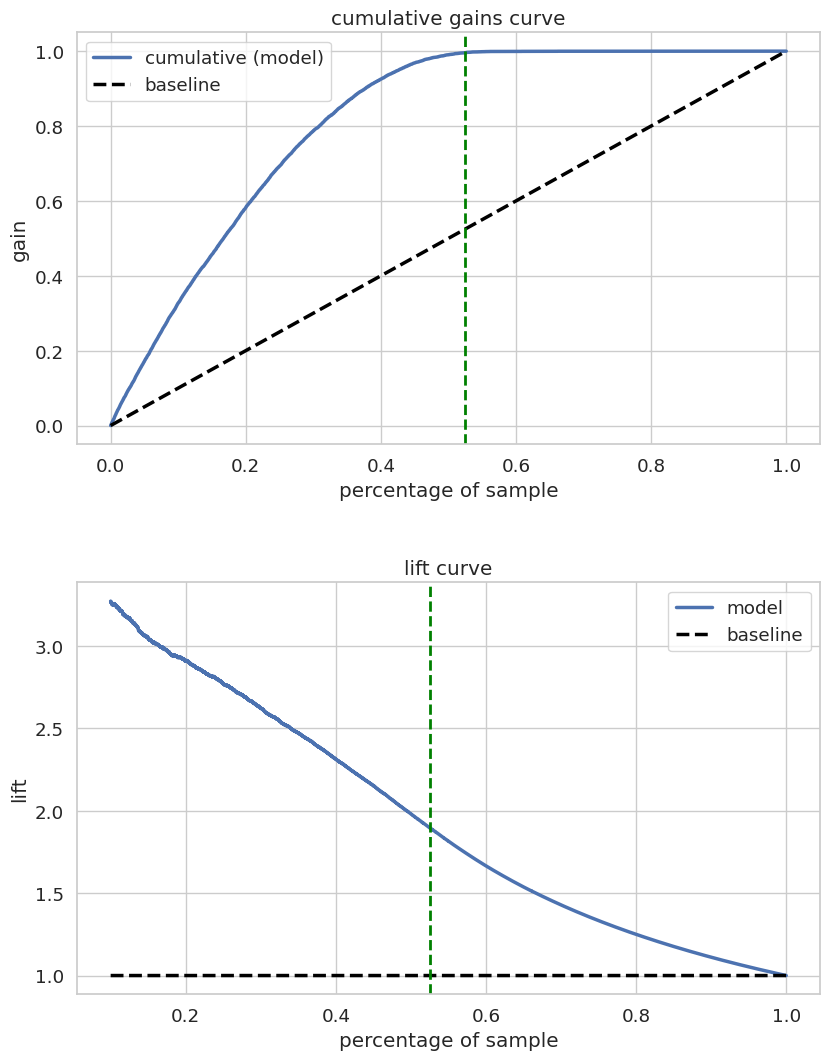

In [73]:
curves_at_40k = lift_curve(yhat_proba_xgb_final, y_test1, size = (10, 12), axvline= percent_at_40)

In [74]:
## Cenario com 40000 ligações.

df_fin = pd.read_csv(path_data+'df4_Feature_Engineering.csv', index_col=0)

print (f"Temos {data.shape[0]} novos clientes, dos quais {round(data.loc[data['target'] == 1].shape[0])} estão interessados no seguro de veiculos. ({round(data.loc[data['target'] == 1].shape[0] / data.shape[0] *100 ,2) }% do total de novos clientes)")

print (f"O ticket médio para um seguro de saúde anual da Insurance All é de: ${round(df_fin['annual_premium'].median())}.")

print (f"\nAssumindo que todos os clientes interessados no seguro de veículo irão contratar o seguro de automovel, e que o valor médio do seguro do veículo será o mesmo do seguro de saúde, podemos estimar como cenario de faturamento:")

print (f"\n_______________________________ Cenario para 40000 Ligações telefonica _____________________________________________________________________________")
print (f"Pela Lista Aleatória:")
print (f" - A equipe de vendas contata {round(40000 / data.shape[0]*100 )}% dos interessados em seguro de carro: {round( (40000 / data.shape[0]*100 ) / 100 * (round(data.loc[data['target'] == 1].shape[0])) )} clientes (Ganho: Linha preta x linha Verde).\n  ==>  Receita estimada: 4905 * 31669 = ${nm.numerize(155336445)} por ano.")       

print (f"\nPela Lista ordenada (modelo):")
print (f" - A equipe de vendas contata {round(recall_at_40k[1]*100)}% dos interessados em seguro de automovel: {round( recall_at_40k[1]*100  / 100 * (data.loc[data['target'] == 1].shape[0]) )} Clientes (Ganho: cruzamento linha azul x linha verde).\n  ==> Receita Estimada: {round( recall_at_40k[1]*100  / 100 * (data.loc[data['target'] == 1].shape[0]) )} * 31669 = ${nm.numerize(294711714)} por ano.")

print (f"\nRESULTADO: O modelo é {round(294711714 / 155336445 ,2)} vezes melhor que a lista aleatória (Lift: Intereseção linha azul x verde). \nPortando, a receita estimada é de {round(294711714 / 155336445 ,2)} vezes maior que a lista aleatória: ${nm.numerize(294711714 - 155336445)}.")

Temos 76219 novos clientes, dos quais 9347 estão interessados no seguro de veiculos. (12.26% do total de novos clientes)
O ticket médio para um seguro de saúde anual da Insurance All é de: $31683.

Assumindo que todos os clientes interessados no seguro de veículo irão contratar o seguro de automovel, e que o valor médio do seguro do veículo será o mesmo do seguro de saúde, podemos estimar como cenario de faturamento:

_______________________________ Cenario para 40000 Ligações telefonica _____________________________________________________________________________
Pela Lista Aleatória:
 - A equipe de vendas contata 52% dos interessados em seguro de carro: 4905 clientes (Ganho: Linha preta x linha Verde).
  ==>  Receita estimada: 4905 * 31669 = $155.34M por ano.

Pela Lista ordenada (modelo):
 - A equipe de vendas contata 100% dos interessados em seguro de automovel: 9306 Clientes (Ganho: cruzamento linha azul x linha verde).
  ==> Receita Estimada: 9306 * 31669 = $294.71M por ano.

RES

## Quantas ligações a equipe de vendas precisa fazer para entrar em contato com 80% dos clientes interessados em Adquirur o seguro de veículo?

In [75]:
percent_at_23k = 23800 / len(data)
recall_at_23k, table_23k = precision_recall(data, k=23800)

print(percent_at_23k)
print(recall_at_23k[1])


0.3122580983744211
0.8057130630148711


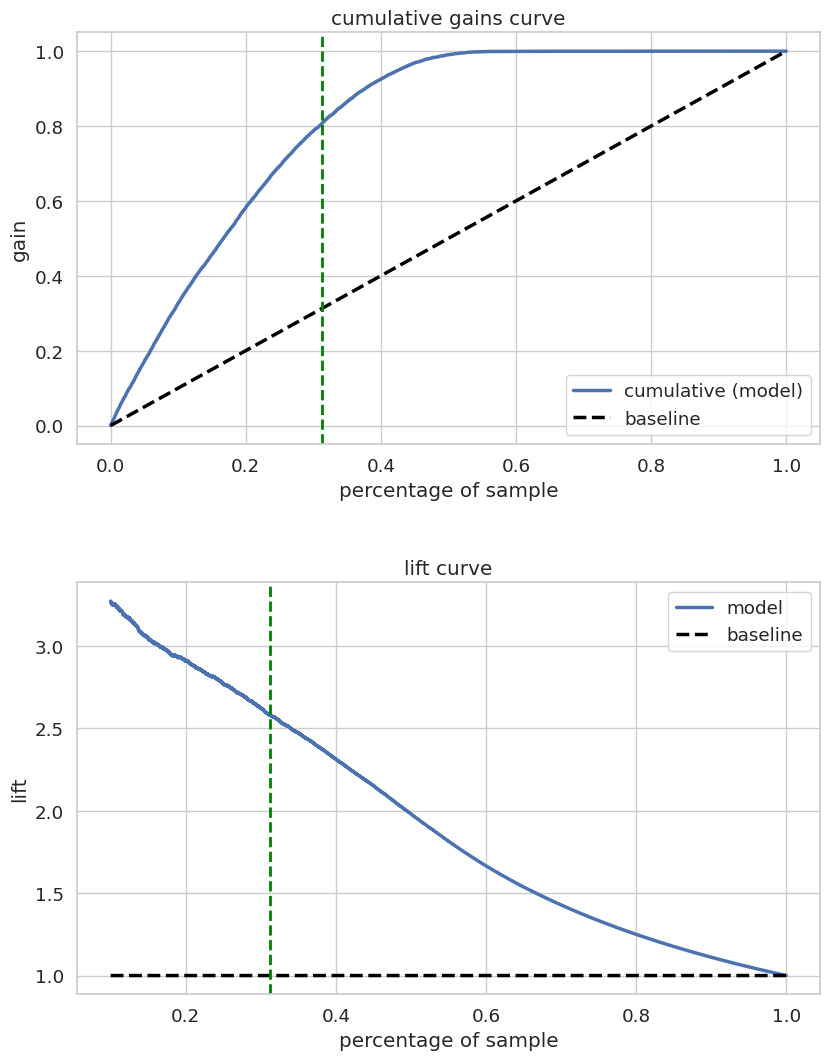

In [76]:
curves_at_23k = lift_curve(yhat_proba_xgb_final, y_test, size = (10, 12), axvline=percent_at_23k)

In [77]:
## Cenario com 80% dos interessados.

print(f"Lista Aleatória:")
print(f" - A esquipe de vendas precisa fazer {round(0.8 * 76220)} ligações, para entrar em contato com 80% dos clientes da lista, então chegará em 80% dos interessados em seguro de carro.")

print (f"\nPela Lista ordenada (modelo):")
print (f" - A equipe de vendas precisa fazer 23800 ligações, para entrar em contato {round(percent_at_23k*100)}% dos clientes da lista, então chegará a : {round( recall_at_23k[1]*100)}% dos interessados em seguro de carro (Ganho: cruzamento linha azul x verde.") 

print (f"\nRESULTADO: Fazendo 23800 chamadas, o modelo é {round(60976 / 23800 ,2)} vezes melhor que a lista aleatória (Lift: Interseção linha azul x verde")

Lista Aleatória:
 - A esquipe de vendas precisa fazer 60976 ligações, para entrar em contato com 80% dos clientes da lista, então chegará em 80% dos interessados em seguro de carro.

Pela Lista ordenada (modelo):
 - A equipe de vendas precisa fazer 23800 ligações, para entrar em contato 31% dos clientes da lista, então chegará a : 81% dos interessados em seguro de carro (Ganho: cruzamento linha azul x verde.

RESULTADO: Fazendo 23800 chamadas, o modelo é 2.56 vezes melhor que a lista aleatória (Lift: Interseção linha azul x verde


# Deploy Model

### Health Insurance Class

A classe a seguir foi criada para ser o pipeline do modelo em produção, contendo todas as etapas necessárias para realizar as probabilidades de previsão: Limpeza dos dados, engenharia de features, preparação dos dados e a previsão.

A API foi implantanda no Heroku Cloud: 

In [133]:
import pickle
import numpy as np
import pandas as pd

class HealthInsurance( object ):
    def __init__(self):

        self.home_path = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/health_insurance_app/'

        self.annual_premium_scaler              =    pickle.load( open( self.home_path + 'features/health_annual_paid_scaler.pkl', 'rb'))    

        self.health_vintage_scaler              =    pickle.load( open( self.home_path + 'features/vintage_mms.pkl', 'rb'))
        self.age_scaler                         =    pickle.load( open( self.home_path + 'features/age_scaler.pkl', 'rb'))
        
        self.gender_target_encoder              =    pickle.load( open( self.home_path + 'features/target_encoder_gender.pkl', 'rb'))
        self.region_code_target_encoder         =    pickle.load( open( self.home_path + 'features/target_encoder_region_code.pkl', 'rb'))
        self.policy_sales_code_target_encoder   =    pickle.load( open( self.home_path + 'features/freq_policy_sales_channel.pkl', 'rb'))


def feature_engineering(self, df3):

    dict_vehicle_age = {'> 2 Years': 'over_2_year', '1-2 Year': 'beetween_1_1_year', '< 1 Year': 'below_1_year' }
    df3['vehicle_age'] = df3['vehicle_age'].map(dict_vehicle_age)
    df3['vehicle_age'].value_counts()


    dict_vehicle_damage = {'Yes': 1, 'No': 0}
    df3['vehicle_damage'] = df3['vehicle_damage'].map(dict_vehicle_damage)
    df3['vehicle_damage'].value_counts()

    return df3

def data_preparation (self, df5):

    #Standardization
    df5['annual_premium'] = self.annual_premium_scaler.transform( df5[['annual_premium']].values)

    #Rescaling
    df5['age'] = self.age_scaler.transform(df5[['age']].values)
    df5['vintage'] = self.health_vintage_scaler.transform(df5[['vintage']].values)

    #Encoder
    df5.loc[:, 'gender'] = df5['gender'].map(self.gender_target_encoder)
    df5.loc[:, 'region_code'] = df5['region_code'].map(self.region_code_target_encoder)
    df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])
    df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(self.policy_sales_code_target_encoder)

    #Feature Selection
    columns = ['vintage', 'annual_premium', 'age', 'region_code',
       'vehicle_damage', 'policy_sales_channel', 'previously_insured']

    return df5[columns]

def get_prediction (self, model, original_data, test_data):

    #model prediction
    pred = model.predict_proba (test_data)

    #join prediction info original data and sort
    original_data['score'] = pred[: , 1].tolist()
    original_data = original_data.sort_values('score', ascending= False)

    return original_data.to_json(orient= 'records', date_format = 'iso')


        

### API Handler

- A classe a seguir é o manipulador da API, que consumirá a classe criada anteriormente

In [148]:
import pickle
import os
import pandas as np
from flask import Flask, request, Response
#from healthinsurance.HealthInsurance import HealthInsurance

model_path = '/home/wellington/Documentos/Projetos/Projetos_ds_pa/health-insurance-cross-sell.pa04/health_insurance_app/'

#load model in memory
model = pickle.load(open (model_path + 'models/xgbclassifier_model.pkl', 'rb'))

#Initialize API
app = Flask(__name__)

#Criando o Endpoint
@app.route('/predict', methods=['POST'])

def health_insurance_predict():
    test_json = request.get_json()

    if test_json: #There is data
        if isinstance(test_json, dict): #Unique row
            test_raw = pd.DataFrame(test_json, index=[0])

        else: #Multiple rows
            test_raw = pd.DataFrame( test_json, columns= test_json[0].keys())

        test_raw_original = test_raw.copy()

        #Instancindo minha classe
        pipeline = HealthInsurance()

        #Feature engineering
        df1 = pipeline.feature_engineering(test_raw)

        #Data Preparation
        df2 = pipeline.data_preparation(df1)

        #Prediction
        df_response = pipeline.get_prediction(model, test_raw_original, df2)

        return df_response

    else:
        return Response('{}', status = 200, mimetype= 'application/json')


if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run(host='0.0.0.0', port=port)



 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.1.12:5000/ (Press CTRL+C to quit)


### API Teste

Codigo abaixo, faço um teste na API, enviando os dados no formato de json

In [34]:
import requests
import json
import pandas as pd

# loading full test dataset with 76222 rows (simulating production)
df_test = pd.read_csv(path_data+'test_full_data.csv', index_col=0) #3 rows of data
df_test = df_test.drop('response', axis=1).copy() #remove "response"
df_test = df_test.sample(10) #sample
df_test

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage
id,,,,,,,,,,
177715,Male,50,28.0,26.0,1,1-2 Year,Yes,0,40267.0,216
332149,Male,27,41.0,152.0,1,< 1 Year,No,1,33780.0,116
173223,Female,24,18.0,152.0,1,< 1 Year,No,1,25420.0,109
159436,Female,69,8.0,160.0,1,1-2 Year,Yes,0,35528.0,163
357707,Male,46,8.0,7.0,1,1-2 Year,No,1,37235.0,270
6718,Male,52,28.0,26.0,1,1-2 Year,Yes,0,2630.0,155
380989,Female,28,45.0,152.0,1,< 1 Year,No,0,29769.0,279
85490,Male,42,41.0,26.0,1,1-2 Year,No,1,33718.0,104
222316,Female,22,3.0,152.0,1,< 1 Year,No,1,21663.0,100


- Proximos passos, verificar no DS produção a forma que posso testar a API antes de subir para o Heroku

In [35]:
# API Call Prod
data = json.dumps(df_test.to_dict(orient = 'records'))
url = 'https://insurance-well.herokuapp.com/predict'
header = {'Content-type':'application/json'}

r = requests.post( url, data = data, headers = header )
print( 'Status Code {}'.format( r.status_code )) 

Status Code 200


Apos receber um status 200, significa que ocorreu tudo certo com as predições, codigo abaixo recebo o arquivo em formato de json, e converto para DF. visualizando as predições.

In [36]:
df1 = pd.DataFrame(r.json(), columns= r.json()[0].keys())

In [37]:
df1

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,score
0,Male,50,28.0,26.0,1,1-2 Year,Yes,0,40267.0,216,0.647887
1,Male,52,28.0,26.0,1,1-2 Year,Yes,0,2630.0,155,0.362265
2,Female,69,8.0,160.0,1,1-2 Year,Yes,0,35528.0,163,0.062118
3,Female,28,45.0,152.0,1,< 1 Year,No,0,29769.0,279,0.058225
4,Male,46,8.0,7.0,1,1-2 Year,No,1,37235.0,270,0.004205
5,Male,42,41.0,26.0,1,1-2 Year,No,1,33718.0,104,0.001232
6,Male,27,41.0,152.0,1,< 1 Year,No,1,33780.0,116,0.000591
7,Female,24,18.0,152.0,1,< 1 Year,No,1,25420.0,109,0.000454
8,Female,22,3.0,152.0,1,< 1 Year,No,1,21663.0,100,0.000454
9,Female,50,28.0,124.0,1,1-2 Year,No,1,41696.0,191,0.000436
